In [34]:
# Import libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from folium import Map, Choropleth, FeatureGroup, LayerControl, CircleMarker
from folium.features import GeoJsonTooltip
import statsmodels.api as sm
from statsmodels.formula.api import glm
from scipy.stats import poisson
import plotly.express as px
from scipy.stats import linregress

In [2]:
# Read in burglaries, chloropleth, and model data
burglaries = gpd.read_file('../data/aggravated_burglaries.geojson')
chloropleth_data = gpd.read_file('../data/chloropleth_data.geojson')
model_data = pd.read_csv('../data/model_data.csv')

In [3]:
# Create chloropleth map with Folium
map_ = Map(location = [36.1627, -86.7816],
           tiles = 'openstreetmap',
           min_zoom = 10)

map_chloropleth = Choropleth(
    geo_data = chloropleth_data,
    data = chloropleth_data,
    columns = ['tract', 'burglaries_per_1000'],
    key_on = 'feature.properties.tract',
    fill_color = 'YlOrRd',
    bins=[0, 1, 2, 5, 10, 21],
    nan_fill_color = 'lightgrey',
    fill_opacity = 0.65,
    line_color = 'black',
    line_weight = 0.1,
    line_opacity = 1,
    name = 'Choropleth Layer',
    legend_name = 'Aggravated Burglary Incidents per 1,000 Residents',
    highlight = True
).add_to(map_)

map_chloropleth.geojson.add_child(
    GeoJsonTooltip(fields = ['tract',
                             'burglaries_count',
                             'burglaries_per_1000',
                             'population',
                             'median_income'
                            ],
                   aliases = ['Census Tract:',
                              'Total Burglaries:',
                              'Burglaries per 1,000:',
                              'Population:',
                              'Median Income:'
                             ],
                   localize = True,
                  )
)

map_burglaries = FeatureGroup(name = 'Marker Layer', show = False)
map_burglaries.add_to(map_)
LayerControl().add_to(map_)

def plot_burglary(burglary):
    
    CircleMarker(location = [burglary.latitude, burglary.longitude],
                 radius = 2.5,
                 weight = 1,
                 fill_color = 'purple', 
                 fill_opacity = 0.75,
                 color = 'white',
                 tooltip = burglary.incident_location,
                ).add_to(map_burglaries)

burglaries.apply(plot_burglary, axis = 1)

display(map_)
map_.save('burglaries_map.html')

In [4]:
# Build Poisson base model
base_model = glm(formula = 'burglaries_count ~ 1', 
                 data = model_data, 
                 exposure = model_data.population / 1000, 
                 family = sm.families.Poisson()
                ).fit()

display(base_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       burglaries_count   No. Observations:                  157
Model:                            GLM   Df Residuals:                      156
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -607.03
Date:                Mon, 11 Oct 2021   Deviance:                       734.57
Time:                        21:19:07   Pearson chi2:                 1.43e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1777      0.035      5.084      0.000       0.109       0.246
==============================================================================
"""

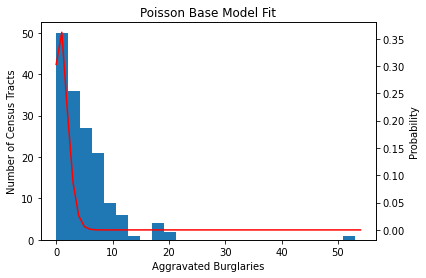

In [5]:
# Plot Poisson base model fit 
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

intercept = base_model.params
x = np.arange(start = 0, stop = 55)
y = poisson.pmf(k = x, mu = np.exp(intercept))

ax1.hist(model_data['burglaries_count'], bins = 25)
ax2.plot(x, y, color = 'red')

ax1.title.set_text('Poisson Base Model Fit')
ax1.set_xlabel('Aggravated Burglaries')
ax1.set_ylabel('Number of Census Tracts')
ax2.set_ylabel('Probability')

plt.show()

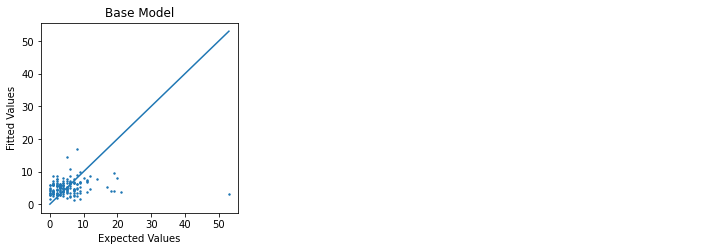

In [6]:
# Plot fitted vs. expected values
model_data['base_fit_values'] = base_model.fittedvalues

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 3.5))

axs[0].scatter(model_data['burglaries_count'], model_data['base_fit_values'], s = 2)
axs[0].plot([0, np.max(model_data['burglaries_count'])], [0, np.max(model_data['burglaries_count'])])
axs[0].title.set_text('Base Model')
axs[0].set_xlabel('Expected Values')
axs[0].set_ylabel('Fitted Values')

axs[1].axis('off')
axs[2].axis('off')

plt.show()

In [7]:
# Build Poisson model with median income as predictor variable
poisson_model = glm(formula = 'burglaries_count ~ median_income', 
                    data = model_data,
                    exposure = model_data.population / 1000,
                    family = sm.families.Poisson()
                   ).fit()

display(poisson_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       burglaries_count   No. Observations:                  157
Model:                            GLM   Df Residuals:                      155
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -532.63
Date:                Mon, 11 Oct 2021   Deviance:                       585.77
Time:                        21:19:07   Pearson chi2:                 1.09e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.2995      0.100     13.046      0.000       1.104       1.495
median_income -1.881e-05    1.7e-06    -11.051      0.000   -2.22e-05   -1.55e-05
=================================================================================
"""

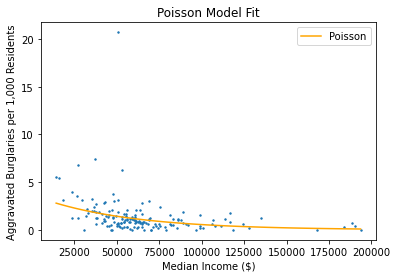

In [8]:
# Plot Poisson and negative binomial model fits
income_range = np.linspace(np.min(model_data['median_income']), np.max(model_data['median_income']))
poisson_fit = poisson_model.predict({'median_income': income_range})

model_data.plot(kind = 'scatter', x = 'median_income', y = 'burglaries_per_1000', s = 2)
plt.plot(income_range, poisson_fit, color = 'orange')
plt.title('Poisson Model Fit')
plt.xlabel('Median Income ($)')
plt.ylabel('Aggravated Burglaries per 1,000 Residents')
plt.legend(['Poisson'])

plt.show()

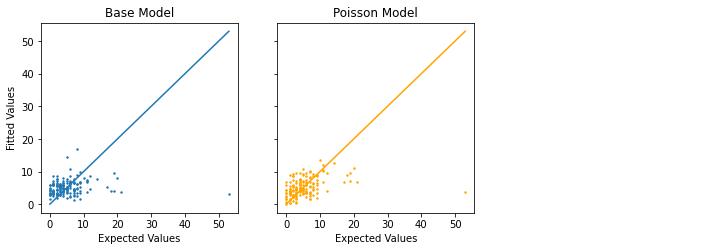

In [9]:
# Plot fitted vs. expected values
model_data['base_fit_values'] = base_model.fittedvalues
model_data['poisson_fit_values'] = poisson_model.fittedvalues

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 3.5))

axs[0].scatter(model_data['burglaries_count'], model_data['base_fit_values'], s = 2)
axs[0].plot([0, np.max(model_data['burglaries_count'])], [0, np.max(model_data['burglaries_count'])])
axs[0].title.set_text('Base Model')
axs[0].set_xlabel('Expected Values')
axs[0].set_ylabel('Fitted Values')

axs[1].scatter(model_data['burglaries_count'], model_data['poisson_fit_values'], color = 'orange', s = 2)
axs[1].plot([0, np.max(model_data['burglaries_count'])], [0, np.max(model_data['burglaries_count'])], color = 'orange')
axs[1].title.set_text('Poisson Model')
axs[1].set_xlabel('Expected Values')
axs[1].label_outer()

axs[2].axis('off')

plt.show()

In [10]:
# Build negative binomial model with median income as predictor variable
neg_binom_model = glm(formula = 'burglaries_count ~ median_income', 
                      data = model_data,
                      exposure = model_data.population / 1000,
                      family = sm.families.NegativeBinomial()
                     ).fit()

display(neg_binom_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       burglaries_count   No. Observations:                  157
Model:                            GLM   Df Residuals:                      155
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -424.91
Date:                Mon, 11 Oct 2021   Deviance:                       108.27
Time:                        21:19:08   Pearson chi2:                     201.
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.2021      0.223      5.380      0.000       0.764       1.640
median_income  -1.56e-05   3.32e-06     -4.696      0.000   -2.21e-05   -9.09e-06
=================================================================================
"""

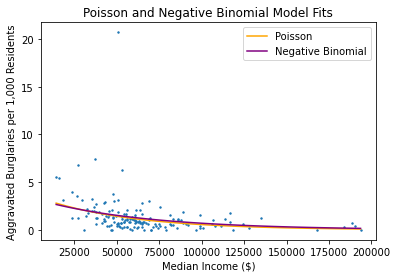

In [11]:
# Plot Poisson and negative binomial model fits
income_range = np.linspace(np.min(model_data['median_income']), np.max(model_data['median_income']))
poisson_fit = poisson_model.predict({'median_income': income_range})
neg_binom_fit = neg_binom_model.predict({'median_income': income_range})

model_data.plot(kind = 'scatter', x = 'median_income', y = 'burglaries_per_1000', s = 2)
plt.plot(income_range, poisson_fit, color = 'orange')
plt.plot(income_range, neg_binom_fit, color = 'purple')
plt.title('Poisson and Negative Binomial Model Fits')
plt.xlabel('Median Income ($)')
plt.ylabel('Aggravated Burglaries per 1,000 Residents')
plt.legend(['Poisson', 'Negative Binomial'])

plt.show()

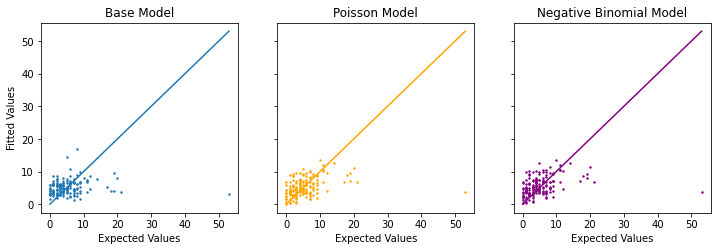

In [12]:
# Plot fitted vs. expected values
model_data['base_fit_values'] = base_model.fittedvalues
model_data['poisson_fit_values'] = poisson_model.fittedvalues
model_data['neg_binom_fit_values'] = neg_binom_model.fittedvalues

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 3.5))

axs[0].scatter(model_data['burglaries_count'], model_data['base_fit_values'], s = 2)
axs[1].scatter(model_data['burglaries_count'], model_data['poisson_fit_values'], color = 'orange', s = 2)
axs[2].scatter(model_data['burglaries_count'], model_data['neg_binom_fit_values'], color = 'purple', s = 2)

axs[0].plot([0, np.max(model_data['burglaries_count'])], [0, np.max(model_data['burglaries_count'])])
axs[1].plot([0, np.max(model_data['burglaries_count'])], [0, np.max(model_data['burglaries_count'])], color = 'orange')
axs[2].plot([0, np.max(model_data['burglaries_count'])], [0, np.max(model_data['burglaries_count'])], color = 'purple')

axs[0].title.set_text('Base Model')
axs[1].title.set_text('Poisson Model')
axs[2].title.set_text('Negative Binomial Model')

axs[0].set_xlabel('Expected Values')
axs[1].set_xlabel('Expected Values')
axs[2].set_xlabel('Expected Values')

axs[0].set_ylabel('Fitted Values')
axs[1].label_outer()
axs[2].label_outer()

plt.show()

In [13]:
# Compare dispersion ratios
base_model_dispersion = base_model.pearson_chi2 / base_model.df_resid
poisson_model_dispersion = poisson_model.pearson_chi2 / poisson_model.df_resid
neg_binom_model_dispersion = neg_binom_model.pearson_chi2 / neg_binom_model.df_resid

print(f'Base Model Dispersion Ratio: {round(base_model_dispersion, 2)}')
print(f'Poisson Model Dispersion Ratio: {round(poisson_model_dispersion, 2)}')
print(f'Negative Binomial Model Dispersion Ratio: {round(neg_binom_model_dispersion, 2)}')

Base Model Dispersion Ratio: 9.15
Poisson Model Dispersion Ratio: 7.03
Negative Binomial Model Dispersion Ratio: 1.3


In [14]:
# Compare AIC values
print(f'Base Model AIC: {round(base_model.aic, 2)}')
print(f'Poisson Model AIC: {round(poisson_model.aic, 2)}')
print(f'Negative Binomial Model AIC: {round(neg_binom_model.aic, 2)}')

Base Model AIC: 1216.06
Poisson Model AIC: 1069.25
Negative Binomial Model AIC: 853.82


In [19]:
model_data.columns

Index(['tract', 'population', 'state', 'county', 'median_income',
       'burglaries_count', 'burglary_rate', 'burglaries_per_1000',
       'base_fit_values', 'poisson_fit_values', 'neg_binom_fit_values'],
      dtype='object')

C:\Users\jacob\Anaconda3\envs\geospatial\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



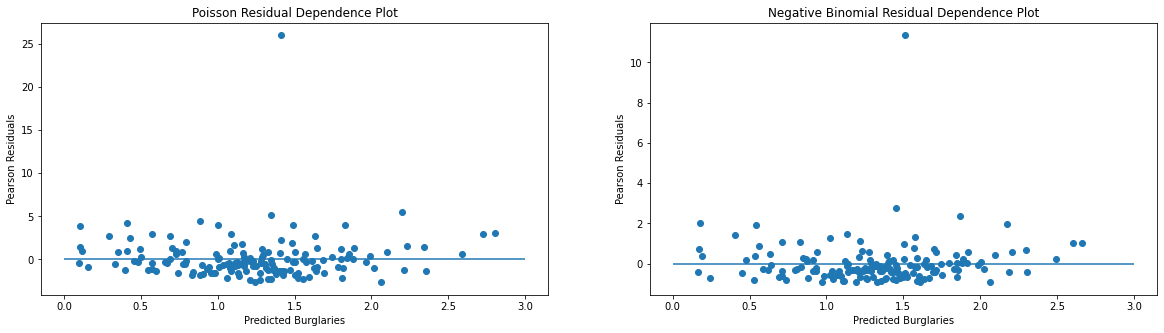

In [52]:
#Residuals Data
poisson_prediction = poisson_model.predict(exog = sm.add_constant(model_data['median_income']))
nbinom_prediction = neg_binom_model.predict(exog = sm.add_constant(model_data['median_income']))
base_model_prediction = base_model.predict(exog = sm.add_constant(model_data['median_income']))

fig, axs = plt.subplots(ncols = 2, nrows=1, figsize = (20,5))

axs[0].scatter(poisson_prediction, poisson_model.resid_pearson)
axs[0].hlines(0, 0, 3)
axs[0].set_title('Poisson Residual Dependence Plot')
axs[0].set_ylabel('Pearson Residuals')
axs[0].set_xlabel('Predicted Burglaries')

axs[1].scatter(nbinom_prediction, neg_binom_model.resid_pearson)
axs[1].hlines(0, 0, 3)
axs[1].set_title('Negative Binomial Residual Dependence Plot')
axs[1].set_ylabel('Pearson Residuals')
axs[1].set_xlabel('Predicted Burglaries');

In [27]:
burglaries['incident_occurred'] = pd.to_datetime(burglaries['incident_occurred'])
burglaries['hour_of_incident'] = burglaries['incident_occurred'].dt.hour

In [32]:

incident_by_hour = (burglaries
                    .drop_duplicates(subset= 'incident_number')
                    .groupby('hour_of_incident')['offense_description']
                    .count()
                   )

incident_by_hour = pd.DataFrame(incident_by_hour)

incident_by_hour = (incident_by_hour.reset_index()
                    .rename(columns = {'offense_description':'Total Burglaries', 
                                       'hour_of_incident':'Hour'})
                   )

incident_by_hour['Sum_of_burglaries'] = incident_by_hour['Total Burglaries'].sum()
incident_by_hour['Probability of Burglary'] = incident_by_hour['Total Burglaries']/incident_by_hour['Sum_of_burglaries']

prob_dist = px.bar(incident_by_hour, x = incident_by_hour['Hour'],
                   y = incident_by_hour['Probability of Burglary'],
                  title = "Probability of Burglary by Hour")
prob_dist.show()

In [38]:
R_squared_poisson = linregress(x = poisson_prediction, y=model_data['burglary_rate']).rvalue**2
R_squared_nbinom = linregress(x = nbinom_prediction, y = model_data['burglary_rate']).rvalue**2
R_squared_base = linregress(x = base_model_prediction, y = model_data['burglary_rate']).rvalue**2

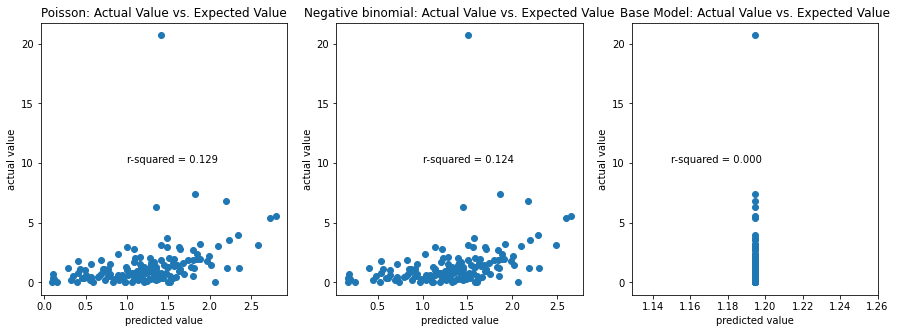

In [51]:
#Actual Value vs. Expected Value

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (15,5))


axs[0].scatter(x = poisson_prediction, 
               y = model_data['burglaries_per_1000'],
              )
axs[0].set_title("Poisson: Actual Value vs. Expected Value")
axs[0].set_xlabel("predicted value")
axs[0].set_ylabel("actual value")
axs[0].annotate("r-squared = {:.3f}".format(R_squared_poisson), xy = (1,10))

axs[1].scatter(x = nbinom_prediction, 
               y = model_data['burglaries_per_1000'],
              )
axs[1].set_title("Negative binomial: Actual Value vs. Expected Value")
axs[1].set_xlabel("predicted value")
axs[1].set_ylabel("actual value")
axs[1].annotate("r-squared = {:.3f}".format(R_squared_nbinom), xy = (1,10));

axs[2].scatter(x = base_model_prediction, 
               y = model_data['burglaries_per_1000'],
              )
axs[2].set_title("Base Model: Actual Value vs. Expected Value")
axs[2].set_xlabel("predicted value")
axs[2].set_ylabel("actual value")
axs[2].annotate("r-squared = {:.3f}".format(R_squared_base), xy = (1.15,10));

In [43]:
model_data['burglaries_per_1000'].max()

20.703125